### Import libraries and packages

In [1]:
# import libraries and packages
import pandas as pd
import requests
from io import StringIO
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# import additional requirements
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marvi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## EDA ##

In [3]:
# Define GitHub URL
url = 'https://raw.githubusercontent.com/mmoran90/ADS-509-Text-Mining/main/combined_df.csv'

# Get CSV content from GitHub
response = requests.get(url)
if response.status_code == 200:
    data = StringIO(response.text)
    maude_df = pd.read_csv(data)
    print(maude_df.head())
else:
    print(f"Error fetching data: {response.status_code}")

   MDRFOI ID                                Brand Name  \
0   20112651  HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL   
1   20112634                          XIENCE SKYPOINT¿   
2   20112157                         TRICLIP G4 SYSTEM   
3   20112156                         TRICLIP G4 SYSTEM   
4   20111290                       PERCLOSE¿ PROSTYLE¿   

                  Model Number  \
0        Model Number 1009664J   
1      Model Number 1804225-18   
2  Catalog Number TCDS0302-XTW   
3  Catalog Number TCDS0302-XTW   
4        Model Number 12773-02   

                                      Device Problem  \
0  Device Problems Difficult to Remove (1528); Ma...   
1  Device Problems Material Rupture (1546); Diffi...   
2        Device Problem Incomplete Coaptation (2507)   
3  Device Problems Positioning Failure (1158); En...   
4             Device Problem Failure to Cycle (1142)   

                                     Patient Problem             Event Date  \
0  Patient Problem Device Embe

In [4]:
# Count the number of null values in the 'CombinedDeviceProblem' column
null_count = maude_df['Device Problem'].isnull().sum()

# Print the result
print(f"Number of null values in 'Device Problem' column: {null_count}")

Number of null values in 'Device Problem' column: 1003


In [5]:
# Count the number of null values in the 'CombinedDeviceProblem' column
null_count = maude_df['Device Problems'].isnull().sum()

# Print the result
print(f"Number of null values in 'Device Problems' column: {null_count}")

Number of null values in 'Device Problems' column: 1415


In [6]:
# Combine 'DeviceProblem' and 'DeviceProblems' based on MDRFOI ID
# Use 'DeviceProblem' if available, otherwise fall back to 'DeviceProblems'
maude_df['Combined Device Problem'] = maude_df['Device Problem'].combine_first(maude_df['Device Problems'])

In [7]:
# Drop the original columns if no longer needed
maude_df.drop(['Device Problem', 'Device Problems'], axis=1, inplace=True)

In [8]:
maude_df.head()

,MDRFOI ID,Brand Name,Model Number,Patient Problem,Event Date,Event Type,Manufacturer Narrative,Event Description,Combined Device Problem
0,20112651,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL,Model Number 1009664J,Patient Problem Device Embedded In Tissue or P...,Event Date 08/12/2024,Event Type Injury,The device was not returned for analysis.A rev...,It was reported the procedure was to treat a l...,Device Problems Difficult to Remove (1528); Ma...
1,20112634,XIENCE SKYPOINT¿,Model Number 1804225-18,"Patient Problem No Clinical Signs, Symptoms or...",Event Date 08/08/2024,Event Type malfunction,The device was not returned for evaluation.Pro...,It was reported that the procedure was to trea...,Device Problems Material Rupture (1546); Diffi...
2,20112157,TRICLIP G4 SYSTEM,Catalog Number TCDS0302-XTW,Patient Problem Tricuspid Valve Insufficiency/...,Event Date 08/14/2024,Event Type malfunction,The device was not returned for analysis.A rev...,It was reported this was a triclip procedure t...,Device Problem Incomplete Coaptation (2507)
3,20112156,TRICLIP G4 SYSTEM,Catalog Number TCDS0302-XTW,"Patient Problem No Clinical Signs, Symptoms or...",Event Date 08/12/2024,Event Type Injury,Investigation is not yet complete.A follow-up ...,It is reported this was a triclip procedure to...,Device Problems Positioning Failure (1158); En...
4,20111290,PERCLOSE¿ PROSTYLE¿,Model Number 12773-02,"Patient Problem No Clinical Signs, Symptoms or...",Event Date 08/09/2024,Event Type Injury,It was reported that this was an arteriotomy c...,Manufacturer's investigation is still pending ...,Device Problem Failure to Cycle (1142)


In [9]:
# Count the number of null values in the 'CombinedDeviceProblem' column
null_count = maude_df['Combined Device Problem'].isnull().sum()

# Print the result
print(f"Number of null values in 'CombinedDeviceProblem' column: {null_count}")

Number of null values in 'CombinedDeviceProblem' column: 423


In [10]:
# Null counts for each column
null_counts = maude_df.isnull().sum()
null_counts

MDRFOI ID                    0
Brand Name                   0
Model Number                23
Patient Problem            101
Event Date                   5
Event Type                   0
Manufacturer Narrative       0
Event Description           37
Combined Device Problem    423
dtype: int64

In [11]:
# Shape before dropping columns
df_shape = maude_df.shape
df_shape

(1995, 9)

In [12]:
# Remove the words "Device Problem" and "Device Problems" from the 'CombinedDeviceProblem' column
maude_df['Combined Device Problem'] = maude_df['Combined Device Problem'].str.replace('Device Problem', '', regex=False)
maude_df['Combined Device Problem'] = maude_df['Combined Device Problem'].str.replace('Device Problems', '', regex=False)
maude_df['Combined Device Problem'] = maude_df['Combined Device Problem'].str.strip()
# Also remove any leading "s " that may have been introduced
maude_df['Combined Device Problem'] = maude_df['Combined Device Problem'].str.lstrip('s ')

# Display the updated column
print(maude_df['Combined Device Problem'].head())

0    Difficult to Remove (1528); Material Separatio...
1    Material Rupture (1546); Difficult to Advance ...
2                         Incomplete Coaptation (2507)
3    Positioning Failure (1158); Entrapment of Devi...
4                              Failure to Cycle (1142)
Name: Combined Device Problem, dtype: object


In [13]:
# Create a copy of maude_df
maude_df_copy = maude_df.copy()

In [14]:
# Split the 'CombinedDeviceProblem' column by ';' into lists using the copy
maude_df_copy['Device Problems List'] = maude_df_copy['Combined Device Problem'].str.split(';')

# Display the updated DataFrame to see the separated lists
print(maude_df_copy[['Combined Device Problem', 'Device Problems List']].head())

                             Combined Device Problem  \
0  Difficult to Remove (1528); Material Separatio...   
1  Material Rupture (1546); Difficult to Advance ...   
2                       Incomplete Coaptation (2507)   
3  Positioning Failure (1158); Entrapment of Devi...   
4                            Failure to Cycle (1142)   

                                Device Problems List  
0  [Difficult to Remove (1528),  Material Separat...  
1  [Material Rupture (1546),  Difficult to Advanc...  
2                     [Incomplete Coaptation (2507)]  
3  [Positioning Failure (1158),  Entrapment of De...  
4                          [Failure to Cycle (1142)]  


In [15]:
# Remove leading/trailing whitespaces from each device problem in the list, handling NaN values
maude_df_copy['Device Problems List'] = maude_df_copy['Device Problems List'].apply(
    lambda x: [problem.strip() for problem in x] if isinstance(x, list) else x
)

# Flatten the list of all device problems into a single list, ignoring NaN values
all_device_problems = maude_df_copy['Device Problems List'].dropna().sum()

# Count the occurrences of each unique device problem
device_problem_counts = pd.Series(all_device_problems).value_counts()

# Display the counts
print(device_problem_counts)

Failure to Cycle (1142)                                          633
Material Separation (1562)                                       158
Leak/Splash (1354)                                               117
Adverse Event Without Identified Device or Use Problem (2993)    111
Difficult to Remove (1528)                                       105
Difficult to Advance (2920)                                       94
Material Rupture (1546)                                           83
Improper or Incorrect Procedure or Method (2017)                  72
Difficult to Open or Close (2921)                                 68
Incomplete Coaptation (2507)                                      51
Failure to Advance (2524)                                         47
Break (1069)                                                      45
Entrapment of Device (1212)                                       38
Off-Label Use (1494)                                              36
Unintended Movement (3026)        

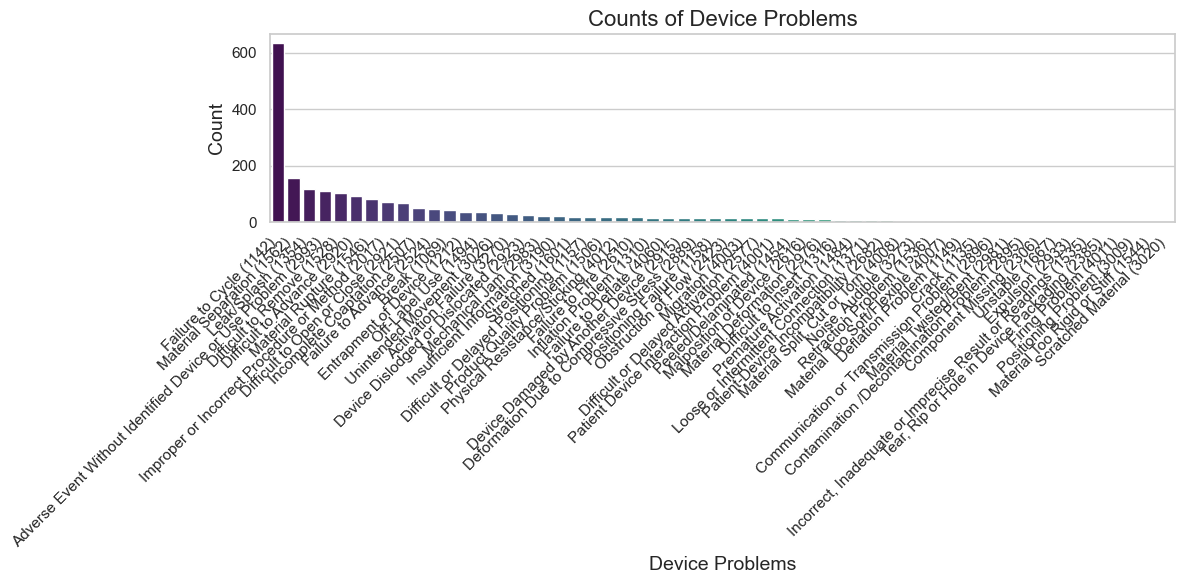

In [16]:
import warnings
warnings.filterwarnings("ignore")

# Set the style of seaborn for better aesthetics
sns.set(style="whitegrid")

# Create a bar plot for device problem counts
plt.figure(figsize=(12, 6))
sns.barplot(x=device_problem_counts.index, y=device_problem_counts.values, palette='viridis')

# Adding titles and labels
plt.title('Counts of Device Problems', fontsize=16)
plt.xlabel('Device Problems', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of tick-labels

# Show the plot
plt.show()

In [17]:
# Get the total count of all device problems
total_device_problem_count = device_problem_counts.sum()

# Display the total count
print(f"Total device problem count: {total_device_problem_count}")

Total device problem count: 2144


In [18]:
# Shape before dropping columns
df_shape_copy = maude_df_copy.shape
df_shape_copy

(1995, 10)

### Descriptive Statistics

In [23]:
### Placeholder for Descriptive Statistics
maude_df_copy.head()

,Brand Name,Patient Problem,Event Type,Manufacturer Narrative,Event Description,Combined Device Problem,Device Problems List
0,HI-TORQUE BALANCE MIDDLEWEIGHT UNIVERSAL,Patient Problem Device Embedded In Tissue or P...,Event Type Injury,The device was not returned for analysis.A rev...,It was reported the procedure was to treat a l...,Difficult to Remove (1528); Material Separatio...,"[Difficult to Remove (1528), Material Separati..."
1,XIENCE SKYPOINT¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type malfunction,The device was not returned for evaluation.Pro...,It was reported that the procedure was to trea...,Material Rupture (1546); Difficult to Advance ...,"[Material Rupture (1546), Difficult to Advance..."
2,TRICLIP G4 SYSTEM,Patient Problem Tricuspid Valve Insufficiency/...,Event Type malfunction,The device was not returned for analysis.A rev...,It was reported this was a triclip procedure t...,Incomplete Coaptation (2507),[Incomplete Coaptation (2507)]
3,TRICLIP G4 SYSTEM,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,Investigation is not yet complete.A follow-up ...,It is reported this was a triclip procedure to...,Positioning Failure (1158); Entrapment of Devi...,"[Positioning Failure (1158), Entrapment of Dev..."
4,PERCLOSE¿ PROSTYLE¿,"Patient Problem No Clinical Signs, Symptoms or...",Event Type Injury,It was reported that this was an arteriotomy c...,Manufacturer's investigation is still pending ...,Failure to Cycle (1142),[Failure to Cycle (1142)]


### Pre-Processing Grouped Data


In [24]:
# remove non-text columns that are irrelevant


In [25]:
# Shape after dropping columns
df_shape_copy = maude_df_copy.shape
df_shape_copy

(1995, 7)

In [26]:
# Combine relevant text columns
maude_df_copy['text'] = maude_df_copy[['Brand Name', 'Combined Device Problem', 'Patient Problem', 'Manufacturer Narrative', 'Event Description']].fillna('').agg(' '.join, axis=1)

# Pre-process text and tokenize using nltk
def clean_and_tokenize_text(text):
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    tokens = word_tokenize(text)  # Tokenize text using nltk
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(tokens)  # Join tokens back into a string

maude_df_copy['clean_text'] = maude_df_copy['text'].apply(clean_and_tokenize_text)

In [27]:
# Target Variable ('Device Problem')
maude_df_copy.dropna(subset=['Combined Device Problem'], inplace=True)  # Drop rows with missing target

# Combine descriptive text and numbers into labels
maude_df_copy['labels'] = maude_df_copy['Combined Device Problem'].apply(lambda x: [re.sub(r'Combined Device Problems? |Combined Device Problem |\(|\)', '', label).strip() for label in x.split(';')])

# Binarize labels (i.e., convert data into binary matrix for multi-label classification)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(maude_df_copy['labels'])

#The fit_transform() converts these lists into a binary matrix, where each unique label becomes a column, and each row has a value of 1 or 0
# indicating whether that label applies to that instance.

## Split Data ##

In [28]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(maude_df_copy['clean_text'], y, test_size=0.3, random_state=42)

## Build SMV Classification Model ##

In [29]:
# Extract featurees using TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [30]:
# Build SVM model (with OneVsRestClassifier for multi-label classification)
svm_model = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
svm_model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=SVC(kernel='linear', random_state=42))

In [31]:
# Predict on test set
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_svm)
classification_rep = classification_report(y_test, y_pred_svm, target_names=mlb.classes_)

print(f"Accuracy: {accuracy}\n")
print("Classification Report:\n", classification_rep)

Accuracy: 0.739406779661017

Classification Report:
                                                              precision    recall  f1-score   support

                                    Activation Failure 3270       1.00      0.44      0.62         9
Adverse Event Without Identified Device or Use Problem 2993       0.96      0.84      0.90        32
                                                 Break 1069       1.00      0.36      0.53        14
                 Communication or Transmission Problem 2896       0.00      0.00      0.00         1
                                     Component Missing 2306       0.00      0.00      0.00         1
                Contamination /Decontamination Problem 2895       0.00      0.00      0.00         1
                                                 Crack 1135       0.00      0.00      0.00         1
                                     Deflation Problem 1149       0.00      0.00      0.00         2
                 Deformation Due to C

## Build XGBoost Classification Model ##

In [32]:
# Build XGBoost model with OneVsRestClassifier for multi-label classification
xgb_model = OneVsRestClassifier(XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42))
xgb_model.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))

In [33]:
# Prediction on test set
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_xgb)
classification_rep = classification_report(y_test, y_pred_xgb, target_names=mlb.classes_)

print(f"Accuracy: {accuracy}\n")
print("Classification Report:\n", classification_rep)

Accuracy: 0.8813559322033898

Classification Report:
                                                              precision    recall  f1-score   support

                                    Activation Failure 3270       0.89      0.89      0.89         9
Adverse Event Without Identified Device or Use Problem 2993       1.00      1.00      1.00        32
                                                 Break 1069       1.00      0.93      0.96        14
                 Communication or Transmission Problem 2896       0.00      0.00      0.00         1
                                     Component Missing 2306       0.00      0.00      0.00         1
                Contamination /Decontamination Problem 2895       0.00      0.00      0.00         1
                                                 Crack 1135       0.00      0.00      0.00         1
                                     Deflation Problem 1149       0.00      0.00      0.00         2
                 Deformation Due to 

In [104]:
# Marvin's comments:
# Class imbalance is a concern for our data set, given that not all reported problems will have all possible device problems.
# Given this, the SVM model performed poorly compared to the XGBoost model. This was expected as XGBoost is the model that
# better handles class imbalances anyway. And, SVM also struggles with multi-class.

# key performance metric to look at here are:
# 1. support = values closer to zero indicate a given label appears very few times in the dataset.
# 2. weighted average = ndicates the overall performance across all classes.

# Next steps --> improve with XGBoost by tuning hyperparameters! Forget SVM :/